In [1]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

# Nos permite obtener nombres y formatos locales, como "Abr" en vez de "Apr".
import locale
# Para Linux y Mac
locale.setlocale(locale.LC_TIME, "es_ES")

'es_ES'

In [2]:
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]

path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )
df_pre = df_pre[ ~ ( (df_pre.index.month == 2) & (df_pre.index.day == 29) ) ]

df = df_pre.resample("M").sum()
df = df.groupby(df.index.month).mean()
tot = df.sum().values[0]

# Precipitación total.
print( f"Total: {tot}" )
# Parciales.
print("Junio, julio, agosto")
print( df[ df.index.isin( [6, 7, 8] ) ].sum().values[0] * 100 / tot )
print("Junio, julio, agosto, septiembre")
print( df[ df.index.isin( [6, 7, 8, 9] ) ].sum().values[0] * 100 / tot )
print("Noviembre, diciembre, enero, febrero")
print( df[ df.index.isin( [11, 12, 1, 2] ) ].sum().values[0] * 100 / tot )

Total: 656.004931373146
Junio, julio, agosto
53.77486072693841
Junio, julio, agosto, septiembre
70.56077026693565
Noviembre, diciembre, enero, febrero
6.512872093644958


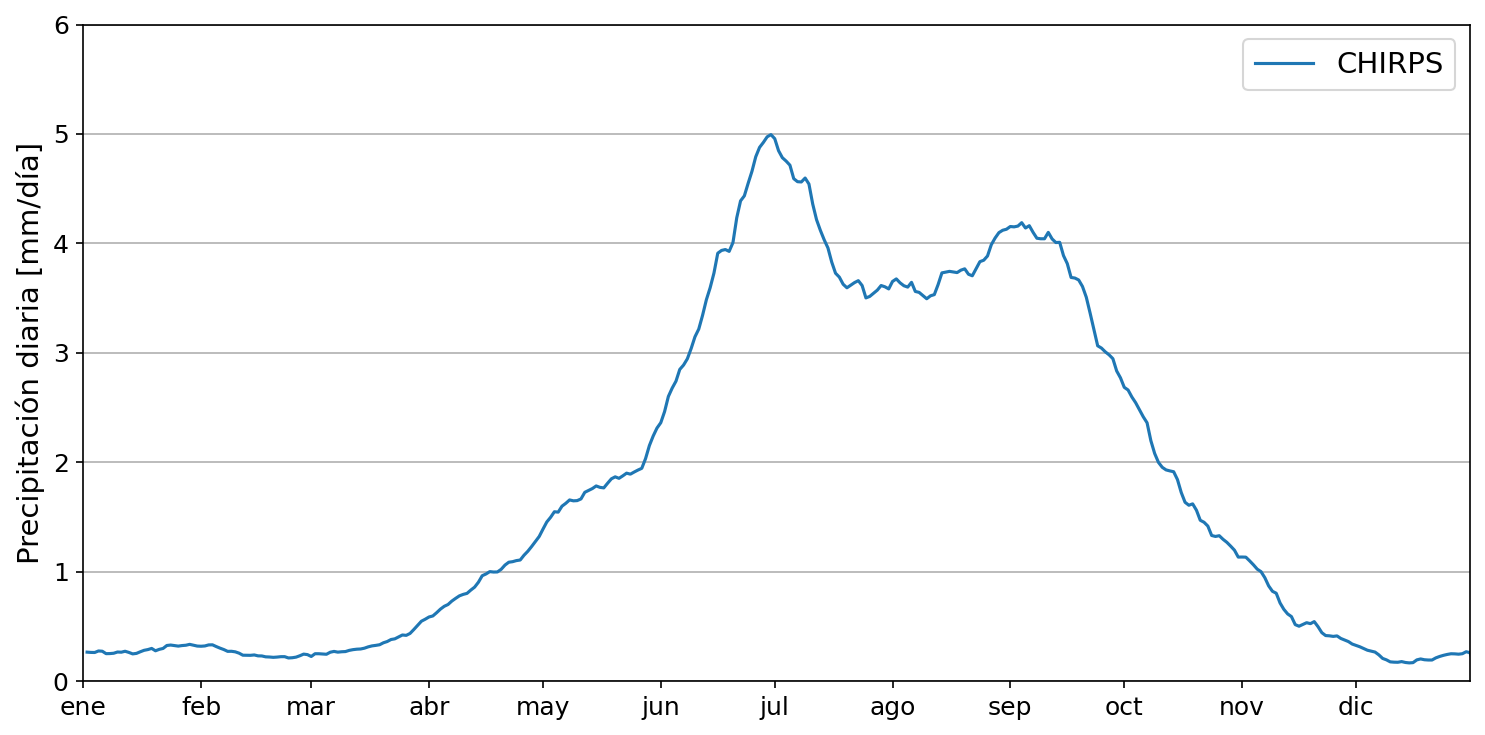

In [3]:
df_mean = df_pre.groupby(df_pre.index.dayofyear).mean()
df_mean.index = ( pd.to_datetime("2000-01-01") 
    + pd.to_timedelta(df_mean.index, "D") )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_mean)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm/día]", fontsize = 14)
ax.tick_params(axis = "both", which = "major", labelsize = 12)
ax.legend(["CHIRPS"], fontsize = 14)
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("2000-01-01"), pd.to_datetime("2000-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "pre_mean_cuenca_CHIRPS.png", bbox_inches = "tight" )

Onset     : 05 June
Withdrawal: 14 October


/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15956/381510021.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ["Ene", "", "Mar", "", "May", "",


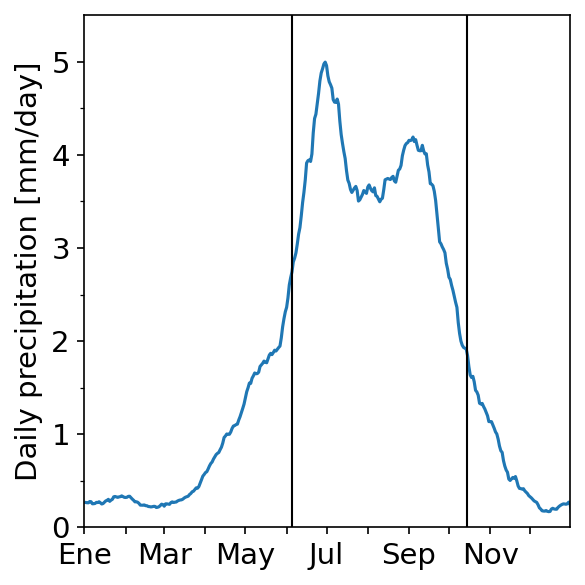

In [4]:
# Cargamos el archivo y ajustamos formatos.
date = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año" )
date.index = pd.RangeIndex(date.index[0], date.index[-1] + 1, name = "Año" )
date.iloc[:, 0] = pd.to_datetime( date.iloc[:, 0] )
date.iloc[:, 1] = pd.to_datetime( date.iloc[:, 1] )

# Convertimos a día juliano.
date.iloc[:, 0] = date.iloc[:, 0].apply(lambda x: x.dayofyear)
date.iloc[:, 1] = date.iloc[:, 1].apply(lambda x: x.dayofyear)
# Ajustamos los años bisiestos.
date.iloc[date.index % 4 == 0, 0:2] = date.iloc[date.index % 4 == 0, 0:2] - 1

# Reconvertimos a fecha.
date.iloc[:, 0] = ( pd.to_datetime("2000-01-01")
    + pd.to_timedelta(date.iloc[:, 0], "D") )
date.iloc[:, 1] = ( pd.to_datetime("2000-01-01")
    + pd.to_timedelta(date.iloc[:, 1], "D") )

# Fechas.
onset = date.iloc[:, 0].mean()
withdrawal = date.iloc[:, 1].mean()

print( f"Onset     : {onset.day:02d}" + f" {onset.month_name()}" )
print( f"Withdrawal: {withdrawal.day:02d}" + f" {withdrawal.month_name()}" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(4, 4)
fig.set_dpi(150)

# Curva suavizada.
ax.plot(df_mean)

# Onset y withdrawal.
ax.plot( (onset, onset), (0, 6), color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal), (0, 6), color = "k", linewidth = 1 )

#ax.grid(axis = "y", which = "both")
ax.set_yticks(np.arange(0, 6, 1))
ax.set_yticks(np.arange(0, 5.5, 0.5), minor = True)
ax.set_ylabel("Daily precipitation [mm/day]", size = 14)
#ax.set_xlabel("Month")
ax.set_ylim(0, 5.5)
ax.set_xlim( pd.to_datetime("2000-01-01"),
    pd.to_datetime("2000-12-31") )
ax.set_title("")
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_xticklabels( ["Ene", "", "Mar", "", "May", "",
    "Jul", "", "Sep", "", "Nov", ""], size = 14 )
ax.set_yticklabels( [str(x) for x in range(0, 6)], size = 14 )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind_cuenca_CHIRPS.pdf", bbox_inches = "tight")


In [14]:
# Fecha media de onset.
onset

Timestamp('2000-06-05 06:36:00')

In [15]:
# Fecha media de withdrawal.
withdrawal

Timestamp('2000-10-14 06:36:00')

In [17]:
# Pendientes máximas de onset en precipitación anual.
df_mean["m"] = ( df_mean["Cuenca"].shift(1) - df_mean["Cuenca"].shift(-1) ) / 2
df_mean[ df_mean.index.month.isin( [5, 6, 7] )
    ].sort_values("m").head(10)

,Cuenca,m
time,,
2000-06-21,4.234900,-0.190351
2000-06-15,3.729798,-0.157474
2000-06-20,4.008231,-0.153559
2000-06-12,3.343607,-0.133662
2000-06-13,3.485616,-0.126198
2000-06-14,3.596002,-0.122091
2000-06-25,4.658906,-0.121230
2000-06-02,2.464022,-0.119867
2000-06-24,4.549671,-0.111919


In [20]:
# Pendientes máximas de withdrawal en precipitación anual.
df_mean[ df_mean.index.month.isin( [9, 10, 11] )
    ].sort_values("m").tail(10)

,Cuenca,m
time,,
2000-10-15,1.843397,0.095120
2000-09-15,3.889416,0.097238
2000-10-09,2.081786,0.099163
2000-09-16,3.815955,0.099877
2000-10-16,1.724888,0.103679
2000-10-07,2.362164,0.109067
2000-09-21,3.509266,0.120891
2000-10-08,2.198709,0.140189
2000-09-22,3.365392,0.146926
